In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import warnings
import healpy as hp
import galsim
from astropy.table import Table

import FoFCatalogMatching
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site('in2p3')

path_folder = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0,path_folder+'/../script/')
import cutout_img_dc2, plot, generate_noiseless

%matplotlib inline
%config InlineBackend.figure_format='retina'

Import images and data

In [6]:
test_data = pd.read_csv('../data/img_data.csv')
psf_img = np.load('../data/psf.npy', mmap_mode = 'c')
gal_img = np.load('../data/img.npy', mmap_mode = 'c')

Check that in the data generated, there are no empty psf images (this can happen in some cases).

In [7]:
index = []
for j in range (len(psf_img)):
    for i in range (6):
        if (np.sum(psf_img[j,:,:,i])==0):
            index.append(j)

In [8]:
index

[]

Here, no problem. Now, to generate noiseless images of galaxies corresponding to the galaxies centred on the DC2 stamps, it is necessary to retrieve the corresponind information from the truth catalog.

In [10]:
# Retrieve information from generation (see: dc2_stamps_and_corresponding_parameters.ipynb)
tract = 4855 # Tract number selected for image generation
N = 10 # Number of images to generate
mag_cut = 24.5

It is necessary to path trough the matching of the two catalogs as done for the generation of the DC2 stamps, in order to have the same indices.

In [11]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
    
    
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')

In [12]:
# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < '+str(mag_cut) ,
]

# Load ra and dec from object, using both of the filters we just defined.

## The validation sample was generated with the tract 3834

object_data = gc_obs.get_quantities(['ra', 'dec', 'r_FLUXMAG0', 'y_FLUXMAG0'],
                                        filters=(mag_filters), native_filters=['tract =='+str(tract)])

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Find required quantities for the noiseless image generation in the truth catalog:

In [17]:
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

truth_mag_filters = ['mag_r < '+str(mag_cut)]
quantities = ['galaxy_id', 'ra', 'dec', 'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'sersic_bulge', 'ellipticity_2_bulge_true', 
              'size_disk_true','ellipticity_1_disk_true', 'ellipticity_2_disk_true', 'sersic_disk',
              'mag_true_Y_lsst', 'mag_true_i_lsst', 'mag_true_g_lsst', 'mag_true_u_lsst', 'mag_true_r_lsst',
              'mag_true_z_lsst', 'size_bulge_true', 'size_disk_true','redshift', 'redshift_true',
             'ellipticity_1_true', 'ellipticity_2_true', 'Mag_true_r_lsst_z0', 'mag_r_lsst', 
              'convergence',
              'shear_1', 'shear_2']

truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

Make FoF matching

In [18]:
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1,
    catalog_len_getter=lambda x: len(x['ra']),
)


# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask


# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

It is now possible to match the data from the generated sample to the matched catalogs.

In [19]:
test_data['id']

0    3501160869
1    2812877231
2    2813047456
3    2814242269
4    3508457789
5    3500111473
6    2128677067
7    2815295465
8    3506000552
9    3500144723
Name: id, dtype: int64

Let's see how to retrieve the parameters from the first object with id=3501160869:

In [20]:
# Define astropy tables composed of the data from the object and truth catalogs.
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))
id_ra_dec_truth = Table.from_pandas(pd.DataFrame.from_dict(truth_data))

# Find, in the data extracted from the truth catalog, where the corresponding id is
in_truth_data = np.where(truth_data['galaxy_id'] == test_data['id'][0])[0][0]

# Then, find the corresponding index in the list "truth_idx":
truth_i = np.where(truth_idx == in_truth_data)[0][0]

It is now possible to get the information from the object table and the truth table:

In [26]:
id_ra_dec[object_idx[truth_i]]

r_FLUXMAG0,y_FLUXMAG0,ra,dec
float64,float64,float64,float64
63095734448.019424,63095734448.019424,63.35628719592693,-29.238575867752047


In [27]:
id_ra_dec_truth[truth_idx[truth_i]]

mag_true_g_lsst,size_bulge_true,redshift,Mag_true_r_lsst_z0,mag_true_z_lsst,ellipticity_2_bulge_true,ellipticity_2_true,mag_r_lsst,ellipticity_1_true,mag_true_Y_lsst,dec,sersic_disk,ellipticity_1_disk_true,mag_true_u_lsst,ellipticity_1_bulge_true,shear_1,ra,galaxy_id,sersic_bulge,redshift_true,ellipticity_2_disk_true,mag_true_r_lsst,bulge_to_total_ratio_i,shear_2,convergence,size_disk_true,mag_true_i_lsst
float32,float32,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float64,float64,int64,float32,float64,float64,float32,float32,float64,float64,float32,float32
25.010088,0.58812344,0.7453352791780901,-21.289616,21.901556,0.08847436857170786,0.09953906047930691,23.56888219346102,-0.053696923047936405,21.623253,-29.238581028574337,1.0,-0.25172007848411954,26.53969,-0.04772801087365497,-0.007020502540053153,63.356287751374936,3501160869,4.0,0.7423254251480103,0.4666185452324455,23.546217,0.97021616,0.007779428281891664,-0.01054671855446121,1.2874085,22.376324


We can do the same for all elements in the sample, and save the corresponding indexes in a list "truth_i":

In [29]:
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))
id_ra_dec_truth = Table.from_pandas(pd.DataFrame.from_dict(truth_data))

truth_i=[]

for i in range (len(test_data['id'])):
    in_truth_data = np.where(truth_data['galaxy_id'] == test_data['id'][i])[0][0]
    truth_i.append(np.where(truth_idx == in_truth_data)[0][0])

Now, we have everything required to generate the noiseless galaxy images:

In [67]:
gal_noiseless_list = []

for i in range (len(gal_img)):
    print(i)
    gal_noiseless_list.append(generate_noiseless.generate_noiseless_img_dc2(i, psf_img, truth_i, truth_data, truth_idx))

0
1
2
3
4
5
6
7
8
9


Let see what it produced and if we can subtract it to the input DC2 images, in the $r$-band:

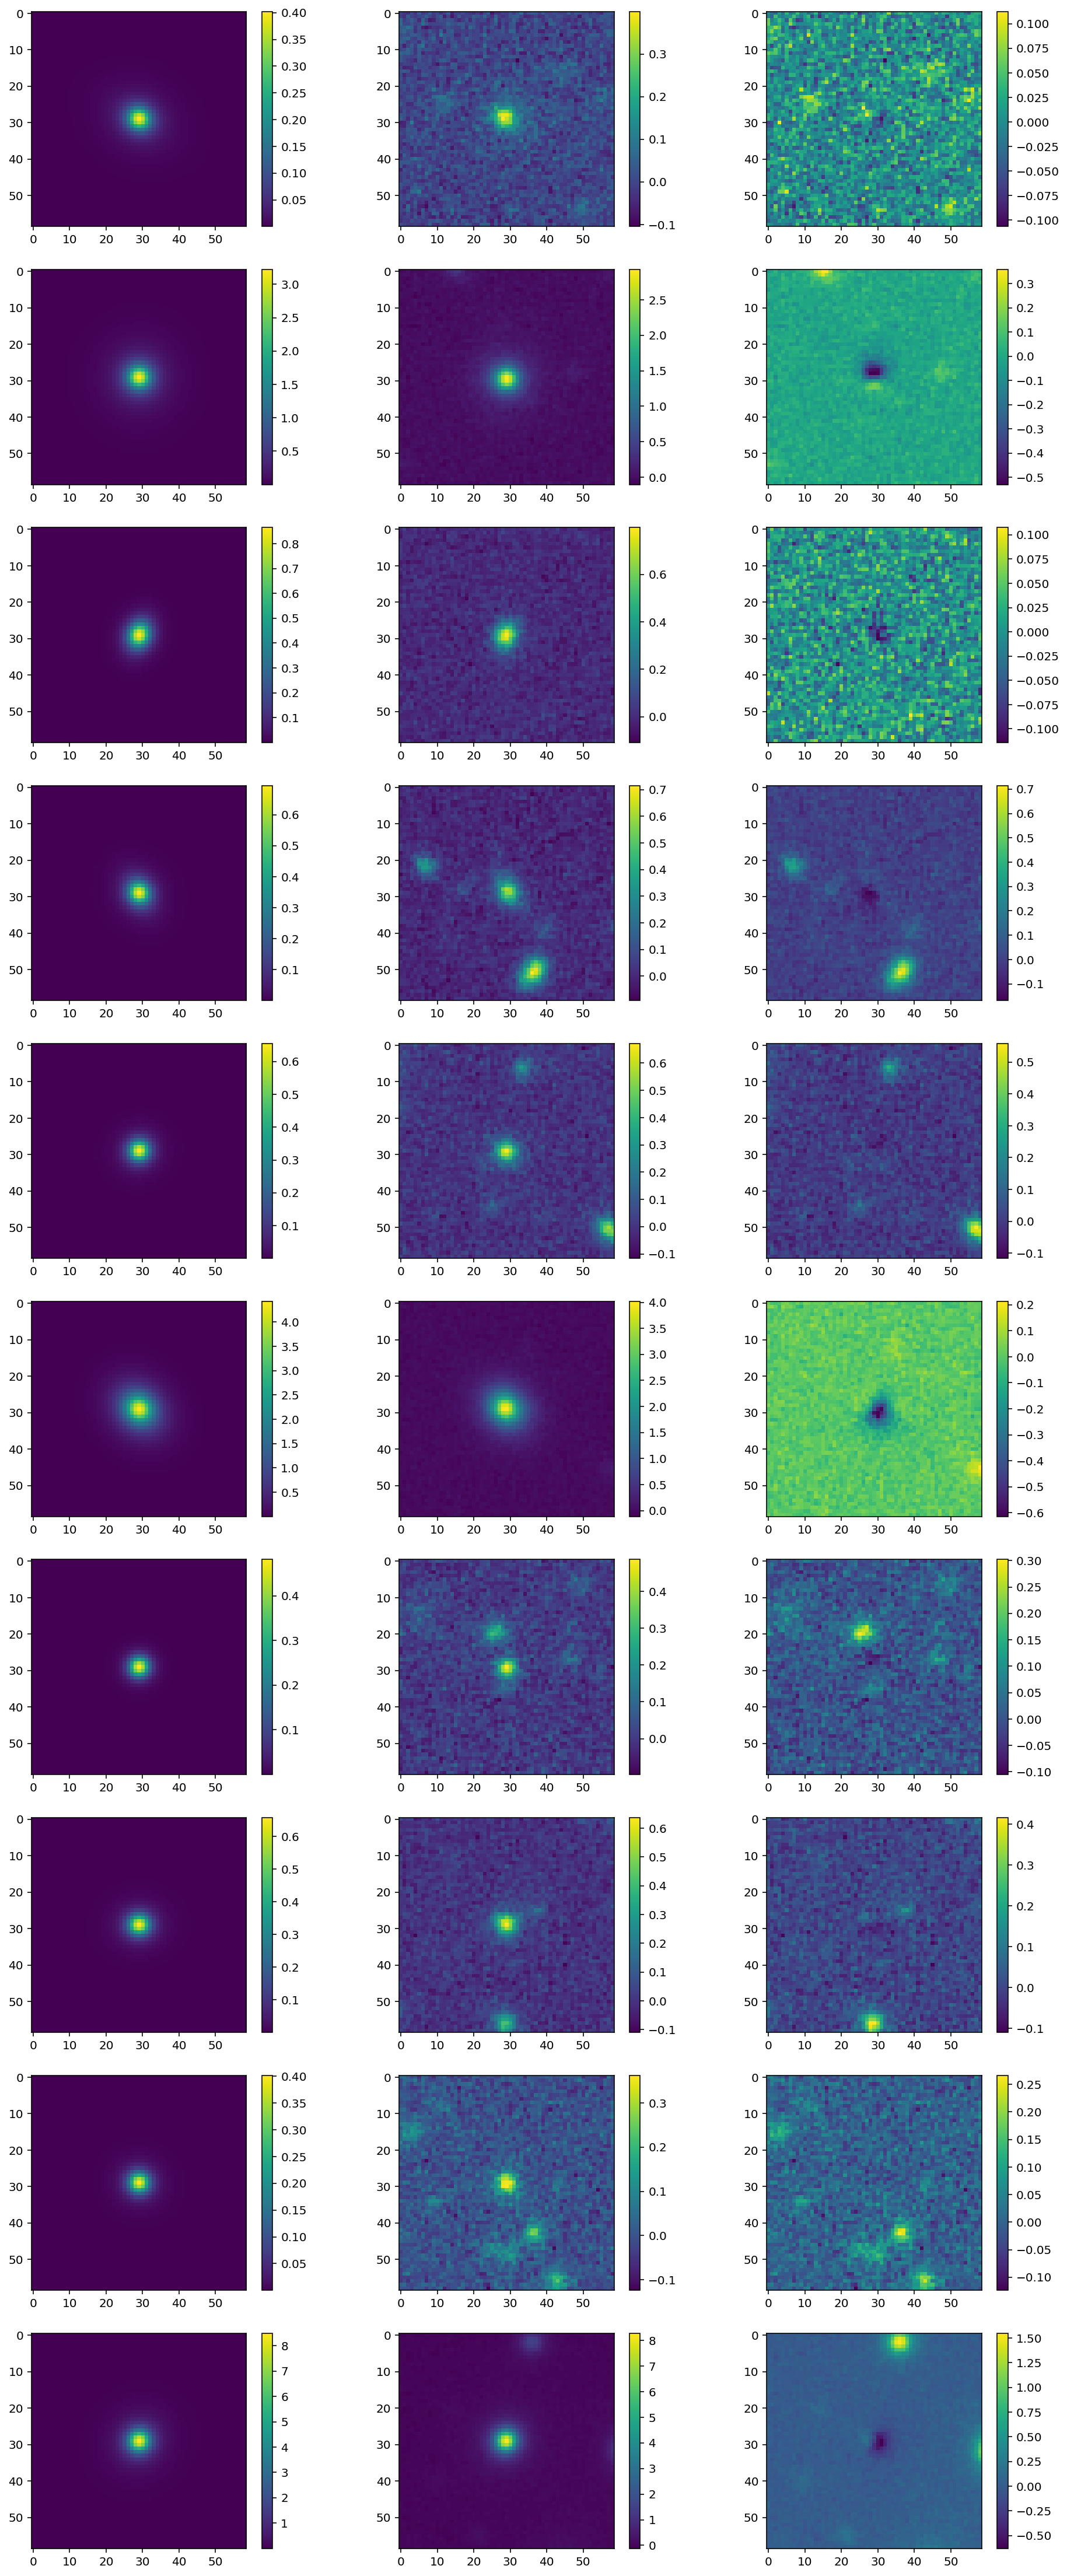

In [68]:
fig, axes = plt.subplots(10,3, figsize =(16,40))

for i in range (10):
    fi1 = axes[i,0].imshow(gal_noiseless_list[i][:,:,2])
    fi2 = axes[i,1].imshow(gal_img[i,:,:,2])
    fi3 = axes[i,2].imshow(gal_img[i,:,:,2]-gal_noiseless_list[i][:,:,2])

    fig.colorbar(fi1, ax=axes[i,0])
    fig.colorbar(fi2, ax=axes[i,1])
    fig.colorbar(fi3, ax=axes[i,2])

Now, in $g$, $r$, and $i$-bands for example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

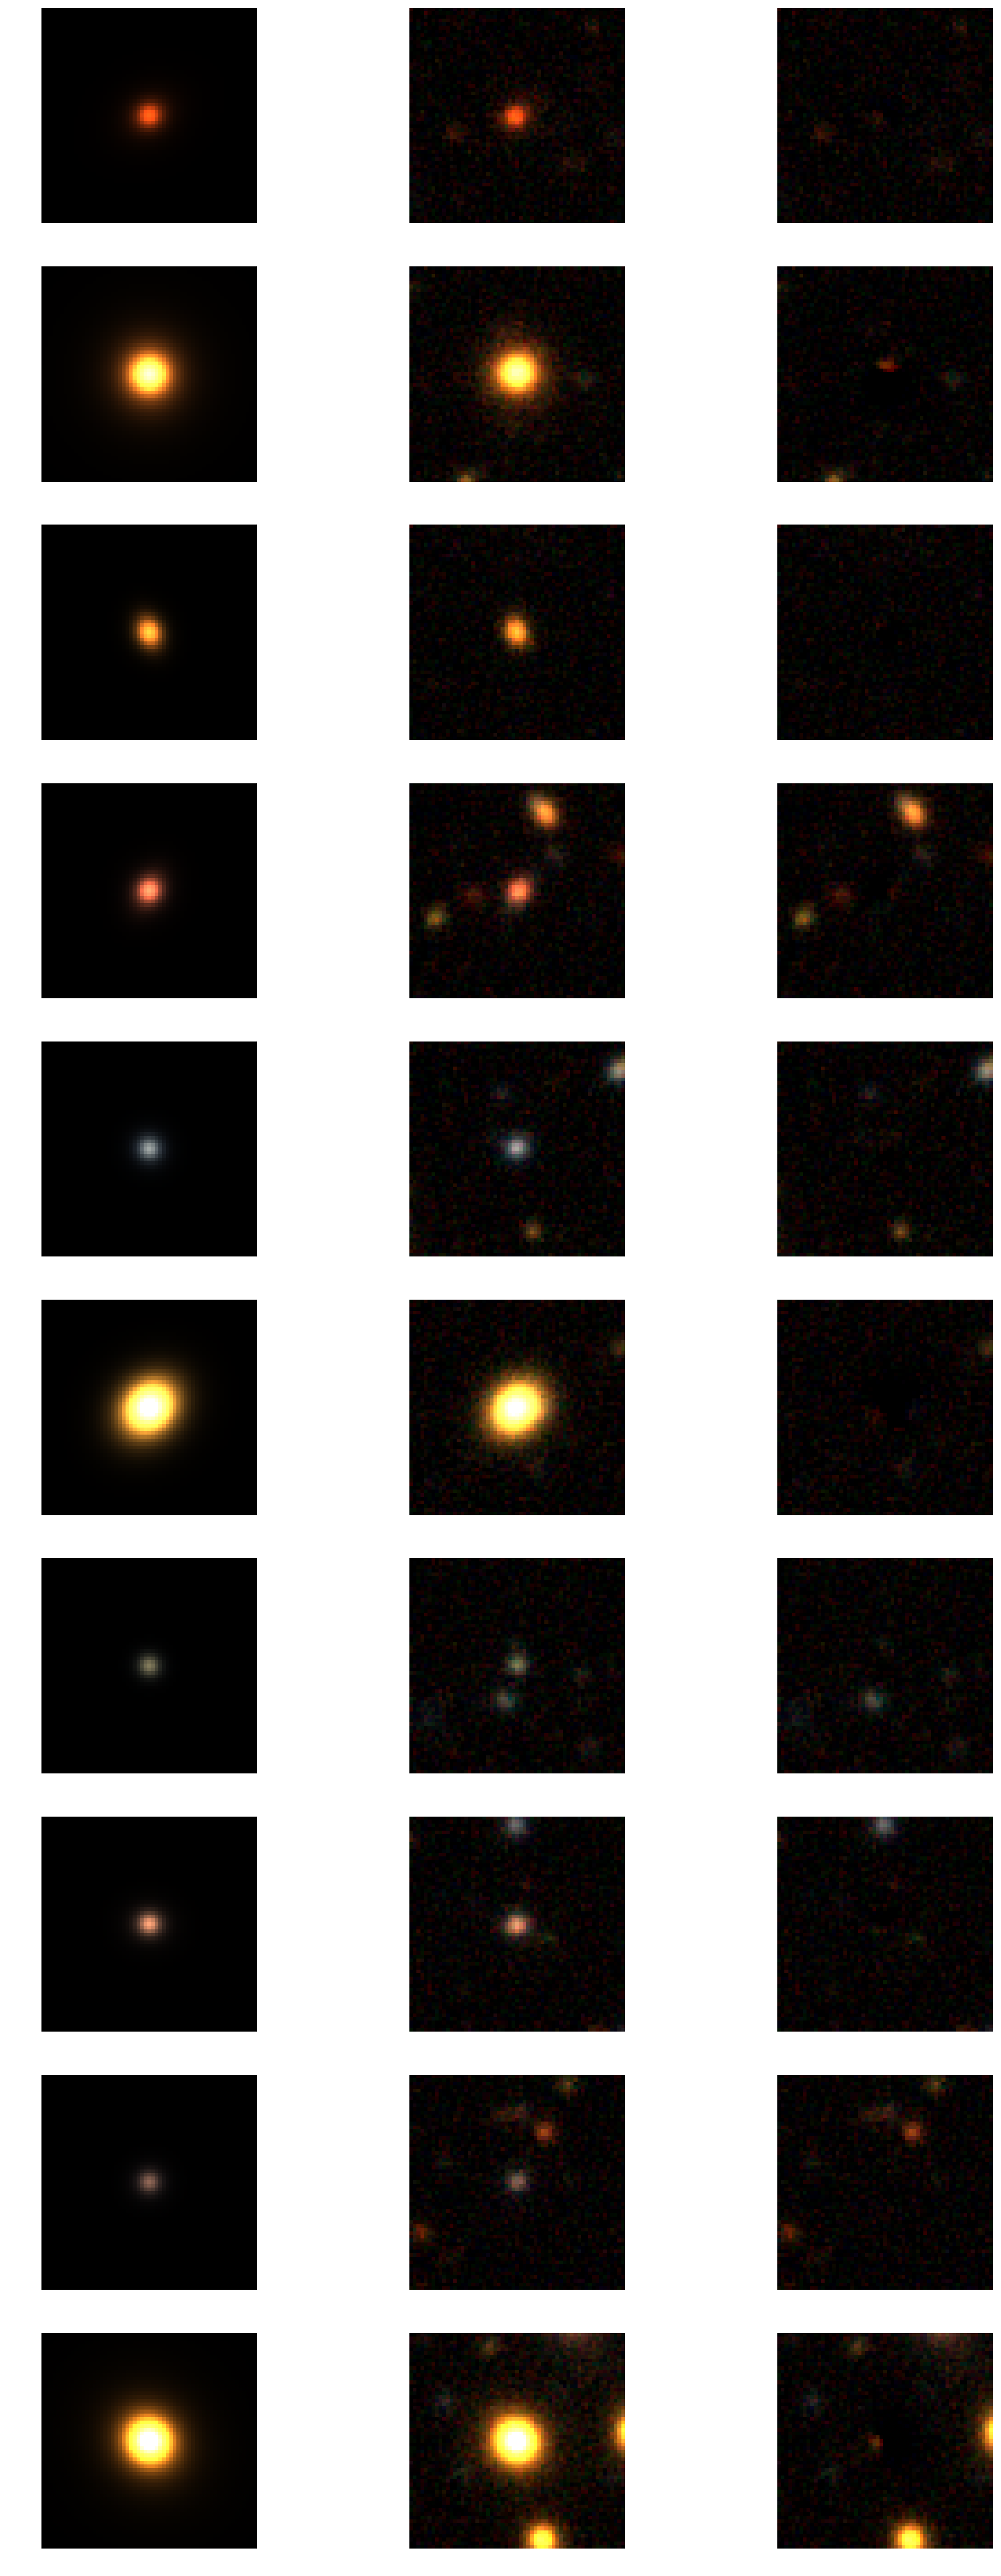

In [69]:
fig, axes = plt.subplots(10,3, figsize =(16,40))

for i in range (10):
    plot.plot_rgb(gal_noiseless_list[i], bands = [3,2,1],ax= axes[i,0], band_first= False,zoom = 1)
    plot.plot_rgb(gal_img[i], bands = [3,2,1],ax= axes[i,1], band_first= False,zoom = 1)
    plot.plot_rgb(gal_img[i]-gal_noiseless_list[i], bands = [3,2,1],ax= axes[i,2], band_first= False,zoom = 1)